# L1, L2 Regularization 실습

이번 실습에서는 **L1, L2 Regularization** 이 Overfitting 완화에 어떻게 도움이 되는지 체감해봅니다.

- 작은 데이터셋과 복잡한 모델로 Overfitting 유도
- Regularization 유무 비교 (L1, L2, L1+L2)
- Validation Loss/Accuracy 곡선으로 비교

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 1. 데이터 준비 (작은 데이터셋 → Overfitting 유도)

In [10]:
# make_moons: 두 개의 반달 모양 클러스터를 생성하는 데이터셋
# n_samples=100: 총 100개의 샘플 (작은 데이터셋 → 과적합 유도)
# noise=0.25: 데이터에 노이즈 추가 (분류 난이도 증가, 과적합 촉진)
# random_state=42: 재현 가능성을 위한 시드 설정
X, y = make_moons(n_samples=100, noise=0.25, random_state=42)

# 데이터를 훈련 세트(70%)와 테스트 세트(30%)로 분할
# 작은 데이터셋이므로 과적합이 쉽게 발생할 수 있음
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# StandardScaler: 데이터를 평균 0, 표준편차 1로 정규화
# 신경망 학습 시 수치 안정성과 수렴 속도를 향상시킴
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # 훈련 데이터로 스케일러 학습 후 변환
X_test = scaler.transform(X_test)         # 테스트 데이터는 학습된 스케일러로만 변환
# 주의: 테스트 데이터에는 fit_transform 사용하지 않음 (데이터 누수 방지)

## 2. 모델 생성 함수 (Regularization 적용 가능)

In [11]:
def build_model(regularizer=None):
    """
    정규화(Regularization)를 적용할 수 있는 모델 생성 함수
    
    Parameters:
    -----------
    regularizer : None, L1, L2, 또는 L1+L2 정규화
        - None: 정규화 없음
        - L1: Lasso 정규화 (가중치의 절댓값을 페널티)
        - L2: Ridge 정규화 (가중치의 제곱을 페널티)
        - L1+L2: Elastic Net (L1과 L2를 결합)
    
    L1 Regularization (Lasso):
    - 손실 함수에 λ × |w| 추가 (가중치의 절댓값 합)
    - 특징: 가중치를 0으로 만드는 효과 (특징 선택, 희소성)
    - 효과: 불필요한 가중치를 완전히 제거하여 모델 단순화
    
    L2 Regularization (Ridge):
    - 손실 함수에 λ × w² 추가 (가중치의 제곱 합)
    - 특징: 가중치를 작게 만드는 효과 (부드러운 제한)
    - 효과: 가중치가 너무 커지지 않도록 제한하여 과적합 방지
    
    L1+L2 Regularization (Elastic Net):
    - L1과 L2를 결합하여 두 효과를 모두 얻음
    - 특징 선택과 가중치 제한을 동시에 수행
    
    kernel_regularizer:
    - Dense 레이어의 가중치(weight)에만 정규화 적용
    - bias는 정규화하지 않음 (일반적인 관행)
    """
    model = tf.keras.Sequential([
        # 첫 번째 은닉층: input_shape로 2차원 입력 정의, 정규화 적용
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizer, input_shape=(2,)),
        # 두 번째 은닉층: 128개 뉴런, 정규화 적용
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizer),
        # 출력층: 이진 분류, 정규화 적용
        tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizer)
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

## 3. Regularization 설정 및 모델 학습

In [12]:
# 네 가지 모델 생성: 정규화 유무와 종류에 따라 비교
models = {
    "No Regularization": build_model(),  # 정규화 없음 (Baseline)
    "L1 (0.001)": build_model(tf.keras.regularizers.l1(0.001)),  # L1 정규화
    "L2 (0.001)": build_model(tf.keras.regularizers.l2(0.001)),  # L2 정규화
    "L1+L2 (0.001)": build_model(tf.keras.regularizers.l1_l2(l1=0.001, l2=0.001))  # Elastic Net
}

# 정규화 강도(0.001) 설명:
# - 너무 작으면 효과가 미미함
# - 너무 크면 모델이 학습을 제대로 하지 못함
# - 0.001은 일반적인 시작값 (하이퍼파라미터 튜닝 필요)

histories = {}

# 각 모델을 학습하고 결과를 비교
for name, model in models.items():
    print(f"Training: {name}")
    # epochs=200: 많은 에포크로 과적합 발생 유도
    # batch_size=16: 작은 배치 크기로 더 부드러운 학습
    # verbose=0: 학습 과정 출력 없음 (진행 상황만 표시)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),  # 검증 데이터로 과적합 여부 확인
        epochs=200,
        batch_size=16,
        verbose=0
    )
    histories[name] = history
    # 예상 결과:
    # - No Regularization: 과적합 발생 (검증 손실 증가)
    # - L1/L2/L1+L2: 과적합이 완화되어 일반화 성능 향상 기대

Training: No Regularization
Training: L1 (0.001)
Training: L2 (0.001)
Training: L1+L2 (0.001)


## 4. 결과 시각화 (Loss & Accuracy)

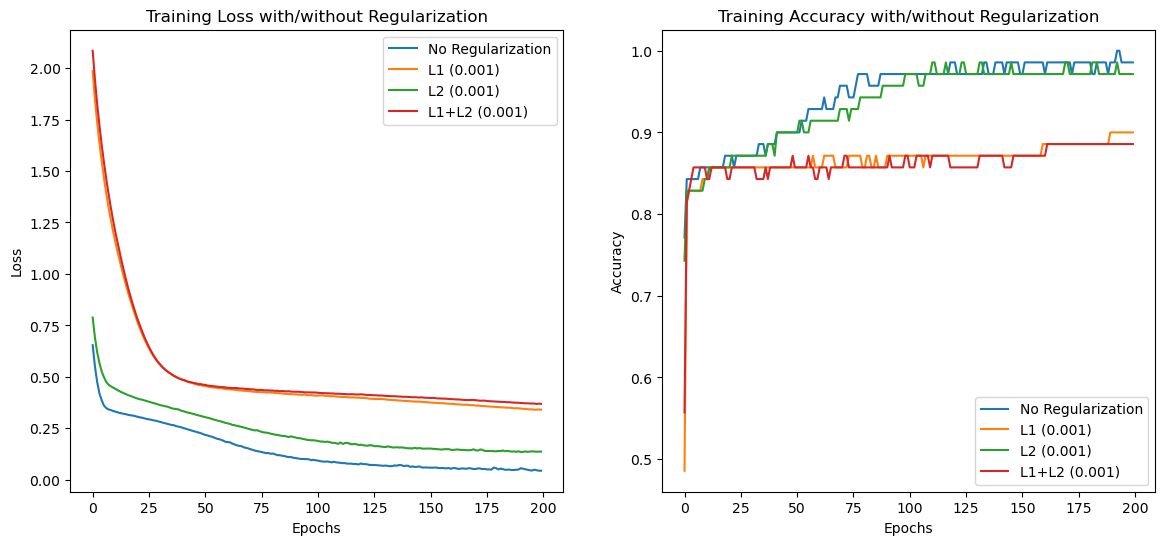

In [13]:
# 훈련 데이터에 대한 성능 비교 그래프
plt.figure(figsize=(14,6))

# 훈련 손실 비교
plt.subplot(1,2,1)
for name, history in histories.items():
    plt.plot(history.history["loss"], label=f"{name}")
plt.title("Training Loss with/without Regularization")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# 예상 결과:
# - No Regularization: 가장 낮은 훈련 손실 (훈련 데이터에 더 잘 맞춤)
# - L1/L2/L1+L2: 정규화로 인해 약간 높은 훈련 손실
# - 하지만 이것이 과적합의 신호일 수 있음 (검증 손실과 비교 필요)

# 훈련 정확도 비교
plt.subplot(1,2,2)
for name, history in histories.items():
    plt.plot(history.history["accuracy"], label=f"{name}")
plt.title("Training Accuracy with/without Regularization")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# 예상 결과:
# - No Regularization: 가장 높은 훈련 정확도
# - L1/L2/L1+L2: 정규화로 인해 약간 낮은 훈련 정확도
# - 하지만 검증 정확도와 비교해야 실제 성능을 알 수 있음

plt.show()

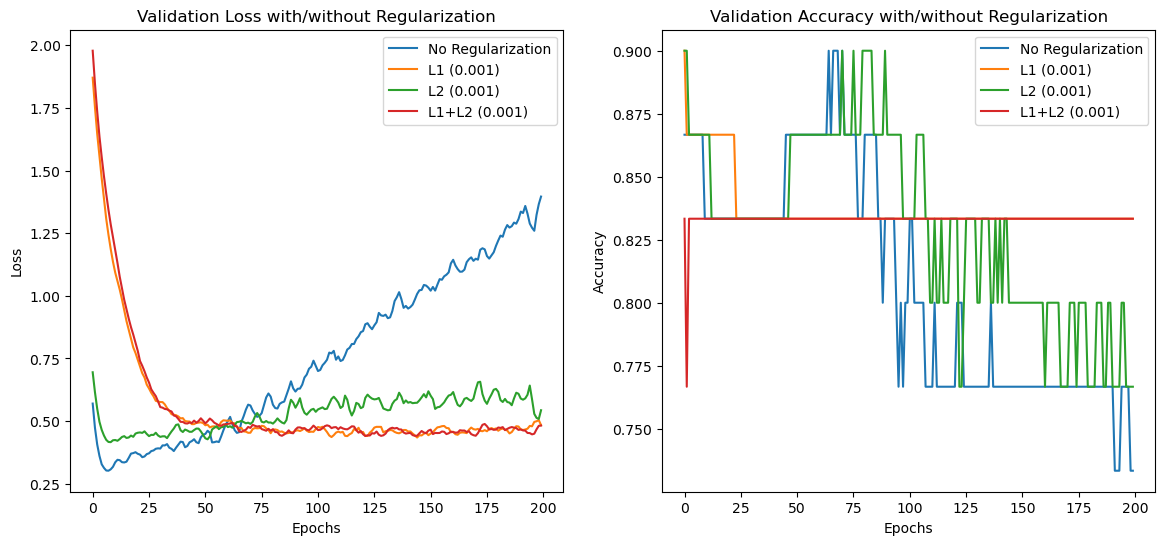

In [14]:
# 검증 데이터에 대한 성능 비교 그래프 (일반화 성능 확인)
plt.figure(figsize=(14,6))

# 검증 손실 비교 - 가장 중요한 지표!
plt.subplot(1,2,1)
for name, history in histories.items():
    plt.plot(history.history["val_loss"], label=f"{name}")
plt.title("Validation Loss with/without Regularization")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# 예상 결과:
# - No Regularization: 초기에는 감소하다가 이후 증가 (과적합 발생)
# - L1/L2/L1+L2: 안정적으로 감소하거나 유지 (일반화 성능 향상)
# 검증 손실이 증가하면 과적합이 발생한 것임
# 정규화가 적용된 모델이 더 낮은 검증 손실을 보일 것으로 예상됨

# 검증 정확도 비교 - 실제 성능 확인
plt.subplot(1,2,2)
for name, history in histories.items():
    plt.plot(history.history["val_accuracy"], label=f"{name}")
plt.title("Validation Accuracy with/without Regularization")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# 예상 결과:
# - No Regularization: 초기에는 증가하다가 이후 감소하거나 정체 (과적합)
# - L1/L2/L1+L2: 안정적으로 증가하고 유지 (일반화 성능 향상)
# 정규화가 적용된 모델이 더 높은 검증 정확도를 보일 것으로 예상됨
# L2가 가장 효과적일 가능성이 높음 (부드러운 제한이 일반적으로 더 효과적)

plt.show()

## 5. 결과 분석 및 도출점

### L1, L2 정규화의 작동 원리

**L1 Regularization (Lasso):**
- **수식**: 손실 함수 + λ × Σ|w|
- **효과**: 가중치의 절댓값을 페널티로 부여
- **특징**: 가중치를 0으로 만드는 효과 (희소성, Sparse)
- **장점**: 불필요한 특징을 완전히 제거하여 모델 단순화
- **단점**: 가중치가 0이 되면 복원 불가능

**L2 Regularization (Ridge):**
- **수식**: 손실 함수 + λ × Σw²
- **효과**: 가중치의 제곱을 페널티로 부여
- **특징**: 가중치를 작게 만드는 효과 (부드러운 제한)
- **장점**: 가중치가 0에 가까워지지만 완전히 0이 되지는 않음
- **단점**: 모든 가중치를 유지하므로 모델이 여전히 복잡할 수 있음

**L1+L2 Regularization (Elastic Net):**
- **수식**: 손실 함수 + λ₁ × Σ|w| + λ₂ × Σw²
- **효과**: L1과 L2를 결합하여 두 효과를 모두 얻음
- **특징**: 특징 선택(L1)과 가중치 제한(L2)을 동시에 수행

---

## 주요 도출점

### 1. 훈련 손실 vs 검증 손실 비교

**No Regularization (예상 결과):**
- **훈련 손실**: 지속적으로 감소 → 매우 낮은 수준 도달
- **검증 손실**: 초기 감소 후 증가 → 과적합 발생
- **차이**: 훈련 손실과 검증 손실 사이의 큰 격차 발생

**L1/L2/L1+L2 Regularization (예상 결과):**
- **훈련 손실**: 완만하게 감소 (정규화로 인해 약간 높음)
- **검증 손실**: 안정적으로 감소하고 유지 → 일반화 성공
- **차이**: 훈련 손실과 검증 손실이 비슷하게 유지

**교훈:**
- 훈련 손실만 낮다고 좋은 모델이 아님
- **검증 손실이 가장 중요한 지표** → 실제 성능을 반영
- 두 손실 간의 격차가 크면 과적합 신호

---

### 2. 정규화 방법별 비교

**L1 Regularization:**
- **장점**: 가중치를 0으로 만들어 모델 단순화
- **단점**: 신경망에서는 일반적으로 L2보다 덜 효과적
- **적용**: 특징 선택이 중요한 경우 (선형 모델에서 더 효과적)

**L2 Regularization:**
- **장점**: 부드러운 제한으로 일반적으로 더 효과적
- **단점**: 모든 가중치를 유지하므로 모델이 여전히 복잡할 수 있음
- **적용**: 신경망에서 가장 일반적으로 사용되는 정규화 방법

**L1+L2 Regularization:**
- **장점**: 두 방법의 장점을 결합
- **단점**: 하이퍼파라미터가 2개여서 튜닝이 복잡
- **적용**: L1과 L2의 효과를 모두 원하는 경우

**예상 결과:**
- 이 실험에서는 **L2가 가장 효과적**일 가능성이 높음
- L2가 검증 손실을 가장 낮게 유지하고 검증 정확도를 가장 높게 유지
- L1+L2도 비슷한 성능을 보일 수 있음

---

### 3. 정규화 강도(λ)의 중요성

**정규화 강도가 너무 작으면 (예: 0.0001):**
- 효과가 거의 없음
- 과적합이 여전히 발생
- 검증 손실이 증가하는 패턴 유지

**정규화 강도가 적절하면 (예: 0.001):**
- 과적합이 완화됨
- 검증 손실이 안정적으로 유지
- 일반화 성능 향상

**정규화 강도가 너무 크면 (예: 0.1):**
- 모델이 학습을 제대로 하지 못함
- 훈련 손실과 검증 손실이 모두 높음
- **Underfitting 발생** (과소적합)

**교훈:**
- 정규화 강도는 하이퍼파라미터로 튜닝 필요
- 일반적으로 0.001 ~ 0.01 범위에서 시작
- 검증 손실을 모니터링하여 최적값 찾기

---

### 4. 정규화 vs Dropout 비교

**정규화 (L1/L2):**
- 가중치의 크기를 직접 제한
- 모든 뉴런을 사용하되 가중치를 작게 만듦
- 계산 비용이 낮음 (추가 계산 없음)

**Dropout:**
- 뉴런을 무작위로 비활성화
- 학습 시 다른 뉴런 조합 사용
- 앙상블 효과

**언제 무엇을 사용할까?**
- **정규화**: 가중치가 너무 커지는 것을 방지하고 싶을 때
- **Dropout**: 모델이 특정 뉴런에 과도하게 의존하는 것을 방지하고 싶을 때
- **둘 다 사용**: 더 강력한 정규화 효과

---

### 5. 실무 적용 시 고려사항

**1. 정규화 방법 선택:**
- **신경망**: L2 정규화를 기본으로 사용
- **선형 모델**: L1 정규화가 특징 선택에 효과적
- **복잡한 모델**: L1+L2 또는 Dropout과 함께 사용

**2. 정규화 강도 튜닝:**
- 검증 손실을 모니터링하여 최적값 찾기
- 너무 작으면 과적합, 너무 크면 과소적합
- 그리드 서치나 랜덤 서치로 최적값 탐색

**3. 다른 정규화 기법과 조합:**
- **Batch Normalization**: 입력 분포 정규화
- **Dropout**: 뉴런 무작위 비활성화
- **Early Stopping**: 검증 손실 증가 시 학습 중단
- 여러 기법을 함께 사용하여 더 강력한 정규화

**4. 모델 복잡도와의 관계:**
- 복잡한 모델일수록 정규화가 더 중요
- 정규화 없이도 모델 복잡도를 줄여서 과적합 방지 가능
- 하지만 정규화를 사용하면 더 복잡한 모델도 안전하게 사용 가능

---

### 6. 정규화의 수학적 이해

**손실 함수 변화:**

**정규화 없음:**
```
Loss = Binary Crossentropy(y_true, y_pred)
```

**L1 정규화:**
```
Loss = Binary Crossentropy(y_true, y_pred) + λ × Σ|w|
```

**L2 정규화:**
```
Loss = Binary Crossentropy(y_true, y_pred) + λ × Σw²
```

**L1+L2 정규화:**
```
Loss = Binary Crossentropy(y_true, y_pred) + λ₁ × Σ|w| + λ₂ × Σw²
```

**최적화 과정:**
- 정규화 항이 추가되면 가중치가 큰 값에 페널티를 받음
- 옵티마이저가 가중치를 작게 만드는 방향으로 학습
- 결과적으로 모델이 더 단순하고 일반화된 패턴을 학습

---

### 7. 종합적인 결론

1. **정규화는 과적합 방지에 효과적:**
   - 특히 작은 데이터셋과 복잡한 모델에서 유용
   - 검증 손실과 검증 정확도를 안정적으로 유지

2. **L2 정규화가 가장 일반적:**
   - 신경망에서 가장 널리 사용됨
   - 부드러운 제한으로 효과적
   - 이 실험에서도 가장 좋은 성능을 보일 가능성이 높음

3. **정규화 강도가 중요:**
   - 너무 작으면 효과 없음, 너무 크면 과소적합
   - 검증 손실을 모니터링하여 최적값 찾기
   - 일반적으로 0.001 ~ 0.01 범위에서 시작

4. **검증 지표가 중요:**
   - 훈련 손실/정확도만으로는 모델 성능을 판단할 수 없음
   - 검증 손실/정확도를 반드시 확인해야 함
   - 두 지표의 차이가 크면 과적합 신호

5. **실무 권장사항:**
   - 복잡한 모델에서는 기본적으로 L2 정규화 적용 고려
   - 정규화 강도는 0.001을 기본값으로 시작
   - 검증 지표를 모니터링하여 조정
   - Dropout, Early Stopping과 함께 사용하여 최적 성능 확보

6. **과적합의 신호:**
   - 검증 손실이 증가하기 시작
   - 검증 정확도가 정체되거나 감소
   - 훈련 손실과 검증 손실의 큰 격차
   - → 이 경우 정규화 적용 또는 모델 복잡도 감소 필요
